In [1]:
import os
import re

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from keras import utils
from nltk import tokenize
from bs4 import BeautifulSoup
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.layers import Dense, Input, Flatten, Activation, LSTM

Using TensorFlow backend.


In [2]:
base_path = "/kaggle"

# Chech if its in kaggle environment 
if os.path.exists(base_path):
    input_path = os.path.join(base_path, "input", "nlp-getting-started")
    output_path = os.path.join(base_path, "working")
else:
    base_path = "data"
    input_path = base_path
    output_path = os.path.join(base_path, "submissions")


train_file = os.path.join(input_path, "train.csv")
test_file = os.path.join(input_path, "test.csv")

In [3]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
target_names = ["Not real disaster", "Real disaster"]
real_disaster = 1

## Data cleaning

In [5]:
def clean_html_encoding(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    return text


def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)


def remove_urls(text):
    links_reg = re.compile(r'https?://[A-Za-z0-9./]+')
    return links_reg.sub(r'', text)


def remove_mentions(text):
    mentions_reg = re.compile(r'@[A-Za-z0-9]+')
    return mentions_reg.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_puntuation(tokens):
    return [token for token in tokens if token.isalpha()]

def clean_chars_and_contracts(tweet):
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   

    return tweet

def clean_text(text):
    text = clean_html_encoding(text)
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emoji(text)
    
    text = " ".join([word.lower() for word in text.split()])
    text = clean_chars_and_contracts(text)
    
    tokens = tokenize.word_tokenize(text)
    tokens = remove_puntuation(tokens)

    return " ".join(tokens)

In [6]:
train_df.loc[:, "text_cleaned"] = train_df.text.apply(clean_text)
test_df.loc[:, "text_cleaned"] = test_df.text.apply(clean_text)

In [7]:
sample_df = train_df[["text", "text_cleaned"]].sample(n=5)
for text, text_cleaned in zip(sample_df.text, sample_df.text_cleaned):
    print(f"Original:\n{text}")
    print(f"Cleaned:\n{text_cleaned}")
    print("-"*25)

Original:
California School Bus Hijacker Parole Stands http://t.co/kPIVXGjNqt #sacramento
Cleaned:
california school bus hijacker parole stands sacramento
-------------------------
Original:
The #Tribe just keeps sinking everyday it seems faster. As for this year it's been a titanic disaster.
Cleaned:
the tribe just keeps sinking everyday it seems faster as for this year it is been a titanic disaster
-------------------------
Original:
how will I survive without dorrian
Cleaned:
how will i survive without dorrian
-------------------------
Original:
Learn How I Gained Access To The Secrets Of The Top Earners &amp; Used Them To Explode My Home Business Here: http://t.co/dHaMbP54Ya Please #RT
Cleaned:
learn how i gained access to the secrets of the top earners used them to explode my home business here please rt
-------------------------
Original:
Sharing to help our cousin's family http://t.co/LSJowGYvQh
Cleaned:
sharing to help our cousin family
-------------------------


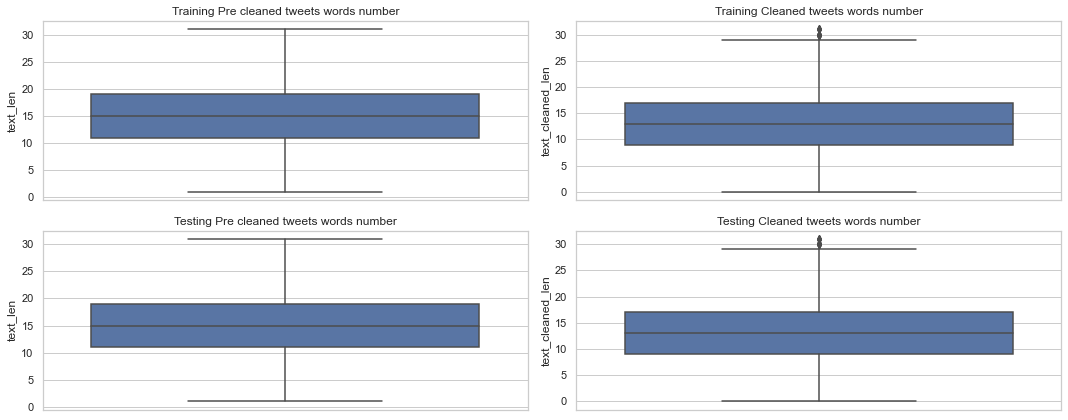

In [8]:
train_df.loc[:, "text_len"] = train_df.text.apply(lambda text: len(text.split()))
train_df.loc[:, "text_cleaned_len"] = train_df.text_cleaned.apply(lambda text: len(text.split()))

test_df.loc[:, "text_len"] = test_df.text.apply(lambda text: len(text.split()))
test_df.loc[:, "text_cleaned_len"] = test_df.text_cleaned.apply(lambda text: len(text.split()))

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_subplot(221)
sns.boxplot(data=train_df, y="text_len", ax=ax1)
ax1.set_title("Training Pre cleaned tweets words number")

ax2 = fig.add_subplot(222)
sns.boxplot(data=train_df, y="text_cleaned_len", ax=ax2)
ax2.set_title("Training Cleaned tweets words number")

ax3 = fig.add_subplot(223)
sns.boxplot(data=train_df, y="text_len", ax=ax3)
ax3.set_title("Testing Pre cleaned tweets words number")

ax4 = fig.add_subplot(224)
sns.boxplot(data=train_df, y="text_cleaned_len", ax=ax4)
ax4.set_title("Testing Cleaned tweets words number")

fig.tight_layout()

### Load GloVe pre-trained weights

In [10]:
from simpletransformers.classification import ClassificationModel

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/_C.cpython-38-darwin.so, 2): Library not loaded: @rpath/libc++.1.dylib
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/_C.cpython-38-darwin.so
  Reason: image not found

### Prediction

In [49]:
test_tweets = test_df.text_cleaned.values.tolist()

test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_data = pad_sequences(test_sequences, maxlen=100, truncating='post', padding='post')

In [50]:
y_pred = model.predict(test_data)

In [51]:
predictions = np.argmax(y_pred, axis=1)

In [52]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [53]:
create_submission_file(predictions, test_df.id, output_path)

Good luck!
